# Check Data Standardization

#### Read an Example File From Each Instrument
1. Make sure the returned flux is with blaze
1. Test continuum fitting (like, that it runs, not what it looks like; see 2a for that)
1. Save a standardized file
1. Confirm common wavelength mask for all four instruments
1. Confirm it matches original file

#### Standardizing Headers
1. Read in a bunch of files
1. Load the results into a pandas data frame
1. Do some nominal visual check of the results

In [6]:
import os
from glob import glob
import numpy as np
import matplotlib.pyplot as plt
from astropy.time import Time
from astropy.io import fits
import pandas as pd
from tqdm import tqdm

import sys
sys.path.append('../')
from data import *
from utils import *
from solarContinuum import solarCont

In [2]:
minax_df = pd.read_csv('../ESSP4/order_wminax.csv')

In [3]:
def standardDataDict(file,inst_name):
    file_name = os.path.join(solar_dir,instrument_nickname2Fullname(inst_name),
                             os.path.basename(file))

    # Read in original data
    wave, spec, errs, blaz = standardizeFile(file_name)

    # Fit continuum
    cont = solarCont(file_name)*blaz

    # Determine mask of wavelengths present in all instruments
    wave = padOrders(wave,inst_name)
    common_mask = np.zeros_like(wave,dtype=bool)
    for iord in range(len(wave)):
        common_mask[iord] = (wave[iord]>=minax_df.at[iord,'Min']) & (wave[iord]<=minax_df.at[iord,'Max'])

    #!!!!# WE'LL CHANGE THE HEADERS HERE EVENTUALLY
    head = standardizeHeader(file_name)

    ### Save file
    data_dict = {
        'wavelength'  : wave.copy(),
        'flux'        : padOrders(spec,inst_name),
        'variance'    : padOrders(errs,inst_name),
        'continuum'   : padOrders(cont,inst_name),
        'common_mask' : common_mask.copy()
    }
    
    return data_dict

In [4]:
def plotOrderChunks(xarr,yarr,line_alpha=None,fig=None,axes=None,color=None,mask=None,
                    ord_per_plot=5,fig_length_per_order=3,cont_plot=True):
    num_ord, num_pix = xarr.shape
    ord_list = np.arange(num_ord)
    if mask is None:
        mask = np.ones_like(xarr).astype(bool)
    if line_alpha is None:
        line_alpha = np.max([0.1,1/num_obs*.5])
    
    if fig is None or axes is None:
        fig, axes = plt.subplots(int(len(ord_list)//ord_per_plot)+1,1,
                                 figsize=(ord_per_plot*fig_length_per_order,
                                          (int(len(ord_list)//ord_per_plot)+1)*3))
    if cont_plot: # assuming it's a continuum plot
        for ax in axes:
            ax.axhline(0,color='0.75',linestyle='--')
            ax.axhline(1,color='k')
            ax.set_ylim(0,1.5)
    
    for iord in range(num_ord):
        if color is None:
            color = f'C{iord%ord_per_plot}'
        axes[int(iord//ord_per_plot)].plot(xarr[iord][mask[iord]],yarr[iord][mask[iord]],
                                           color=color,alpha=line_alpha)
    
    return fig, axes

### Read and Plot Standared Spectrum

harpsn (73, 4096)
harps (73, 4096)
expres (87, 7920)
neid (106, 9216)


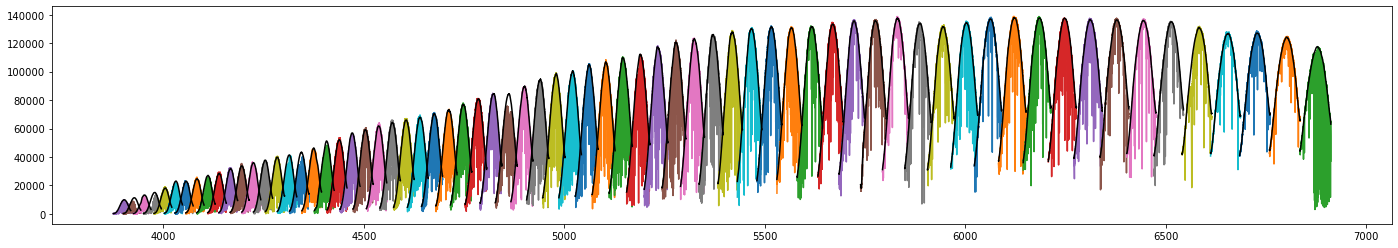

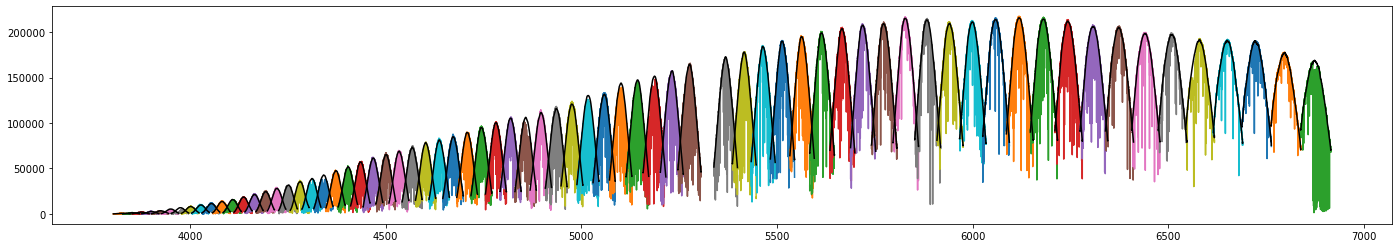

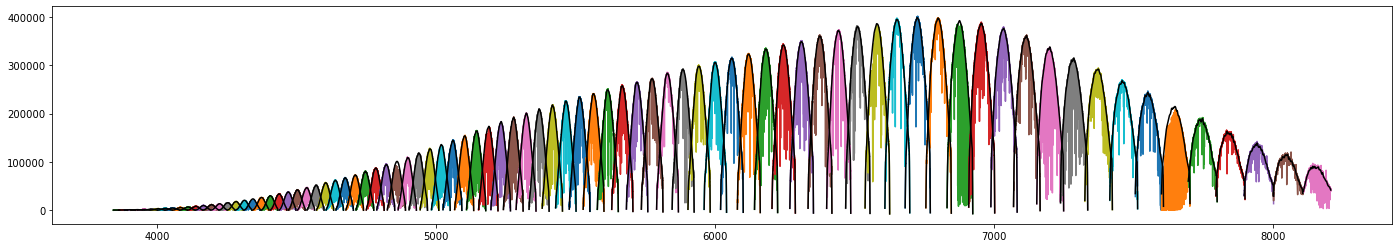

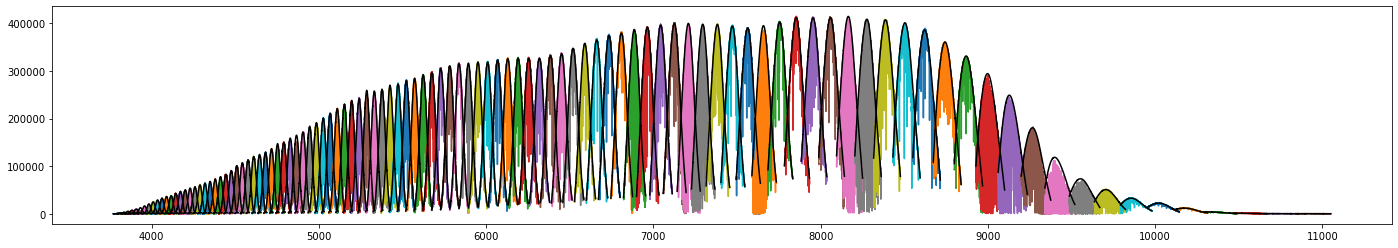

In [5]:
for inst in instruments:
    file = np.random.choice(glob(os.path.join(solar_dir,instrument_nickname2Fullname(inst),'*.fits')))
    data_dict = standardDataDict(file,inst)
    print(inst,data_dict['wavelength'].shape)
    
    plt.figure(figsize=(24,4))
    plt.plot(data_dict['wavelength'].T,data_dict['flux'].T)
    plt.plot(data_dict['wavelength'].T,data_dict['continuum'].T,'k')

### Common Wavelength

100%|██████████| 4/4 [00:19<00:00,  4.77s/it]


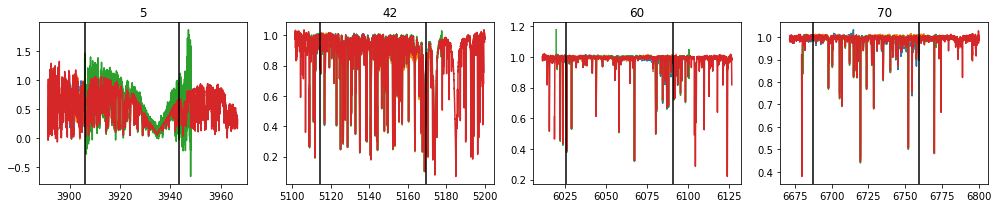

In [10]:
# Mark where the wavelength limits are
iord = 40
ord_list = [5,42,60,70]
fig, axes = plt.subplots(1,len(ord_list),figsize=(len(ord_list)*3.5,3))

for inst in tqdm(instruments):
    file = np.random.choice(glob(os.path.join(solar_dir,instrument_nickname2Fullname(inst),'*.fits')))
    data_dict = standardDataDict(file,inst)
    for iord,nord in enumerate(ord_list):
        axes[iord].plot(data_dict['wavelength'][nord],
                        (data_dict['flux']/data_dict['continuum'])[nord],label=inst)

for iord,nord in enumerate(ord_list):
    ax = axes[iord]
    ax.set_title(nord)
    ax.axvline(minax_df.at[nord,'Min'],color='k')
    ax.axvline(minax_df.at[nord,'Max'],color='k')

fig.tight_layout()

In [ ]:
# Plot orders w/ wavelength mask
fig, axes = None, None
for iinst,inst in enumerate(instruments[::-1]):
    file = glob(os.path.join(solar_dir,instrument_nickname2Fullname(inst),'*.fits'))[0]
    data_dict = standardDataDict(file,inst)
    mask = data_dict['common_mask']
    
    fig, axes = plotOrderChunks(data_dict['wavelength'],
                                data_dict['flux']/data_dict['continuum'],
                                mask = data_dict['common_mask'],
                                fig=fig,axes=axes,
                                line_alpha=.5,color=inst_cols[iinst],
                                ord_per_plot=5,fig_length_per_order=4)

### Confirm Standard File Matches Original

### Standardized Headers
- All headers exist
- Units are right for
  - Time [eMJD/eJD]
  - BERV
  - exptime

In [10]:
dset_num = 0
num_example_obs = 6
head_list = pd.read_csv('../header_map.csv')['keyword'].to_list()
head_dict = {key:[] for key in head_list}
for inst in instruments:
    file_list = np.random.choice(glob(os.path.join(solar_dir,'DataSets',
                                                   '*',f'DS{dset_num}','Spectra',f'*_{inst}.fits')),num_example_obs)
    for file in file_list:
        hdus = fits.open(file)
        for key in head_list:
            head_dict[key].append(hdus[0].header[key])
        hdus.close()

In [11]:
pd.DataFrame(head_dict)

,instrume,program,data-set,filename,date,mjd_utc,jd_utc,exptime,observat,telescop,obslon,obslat,obsalt,airmass,berv,eclord0,origdate
0,HARPS-N,ESSP4,r,/mnt/home/lzhao/ceph/SolarData/HARPS-N_wBlaze/...,2025-04-22T14:00:04.293,59339.996958,2.459340e+06,300.0,TNG,TNG,17.889056,28.754,2387.2,1.171554,-0.068126,161,2021-11-26T07:54:18
1,HARPS-N,ESSP4,r,/mnt/home/lzhao/ceph/SolarData/HARPS-N_wBlaze/...,2025-04-22T13:58:08.947,59339.134035,2.459340e+06,300.0,TNG,TNG,17.889056,28.754,2387.2,1.035795,-0.384732,161,2021-11-26T07:52:17
2,HARPS-N,ESSP4,r,/mnt/home/lzhao/ceph/SolarData/HARPS-N_wBlaze/...,2025-04-22T14:26:14.733,59358.113982,2.459359e+06,300.0,TNG,TNG,17.889056,28.754,2387.2,1.009905,-0.163537,161,2021-11-26T09:11:37
3,HARPS-N,ESSP4,r,/mnt/home/lzhao/ceph/SolarData/HARPS-N_wBlaze/...,2025-04-22T13:50:46.075,59335.207116,2.459336e+06,300.0,TNG,TNG,17.889056,28.754,2387.2,1.270433,-0.559647,161,2021-11-26T07:34:45
4,HARPS-N,ESSP4,r,/mnt/home/lzhao/ceph/SolarData/HARPS-N_wBlaze/...,2025-04-22T14:24:50.077,59356.966567,2.459357e+06,300.0,TNG,TNG,17.889056,28.754,2387.2,1.332167,0.142485,161,2021-11-26T09:03:54
5,HARPS-N,ESSP4,r,/mnt/home/lzhao/ceph/SolarData/HARPS-N_wBlaze/...,2025-04-22T14:04:08.809,59343.041612,2.459344e+06,300.0,TNG,TNG,17.889056,28.754,2387.2,1.048661,-0.137615,161,2021-11-26T08:08:42
6,HARPS,ESSP4,r,/mnt/home/lzhao/ceph/SolarData/HARPS_wBlaze/r....,2025-04-22T14:28:37.033,59359.248222,2.459360e+06,29.9965,TEST,ESO-3P6,-70.73166667,-29.26083333,2400,1.651808,-0.126361,161,2023-02-05T09:13:26
7,HARPS,ESSP4,r,/mnt/home/lzhao/ceph/SolarData/HARPS_wBlaze/r....,2025-04-22T14:03:10.490,59342.176425,2.459343e+06,29.9966,TEST,ESO-3P6,-70.73166667,-29.26083333,2400,1.795841,-0.119502,161,2023-02-05T00:29:33
8,HARPS,ESSP4,r,/mnt/home/lzhao/ceph/SolarData/HARPS_wBlaze/r....,2025-04-22T13:47:53.457,59333.221646,2.459334e+06,29.9965,TEST,ESO-3P6,-70.73166667,-29.26083333,2400,1.583353,-0.277474,161,2023-02-04T17:25:36
9,HARPS,ESSP4,r,/mnt/home/lzhao/ceph/SolarData/HARPS_wBlaze/r....,2025-04-22T14:06:28.822,59345.227760,2.459346e+06,29.9965,TEST,ESO-3P6,-70.73166667,-29.26083333,2400,1.632946,-0.208269,161,2023-02-05T02:40:35
